In [1]:
import pandas as pd
import numpy as np
import pickle
from mlxtend.frequent_patterns import apriori, association_rules
from gensim.models import Word2Vec

#sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN, KMeans

#desbalanceamento
from imblearn.under_sampling import RandomUnderSampler

#word2vec
from gensim.models import Word2Vec

#nltk
import nltk
from nltk.tokenize import word_tokenize, TweetTokenizer
nltk.download('stopwords')
nltk.download('punkt')

#visual
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

#warnings
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
# monta o google drive
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


# Associação (Tóxicos)

In [ ]:
df = pd.read_csv('/content/drive/Shareddrives/Mineração de Dados/data/all_data.csv')
df = df.dropna(subset=['comment_text', 'toxicity'])
df = df.sample(frac=0.01, random_state=42)
X = df.comment_text[df.toxicity >= 0.5]
df = None
stop_words = nltk.corpus.stopwords.words('english')
vect = CountVectorizer(binary = True, stop_words=stop_words, token_pattern='[A-Za-z]+', max_features=1000)
X = vect.fit_transform(X)

In [ ]:
association = pd.DataFrame(X.toarray(), columns=vect.get_feature_names())
freq_itemsets = apriori(association, min_support=0.02, use_colnames=True)
res = association_rules(freq_itemsets, metric='confidence', min_threshold=0.2)
res

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(even),(would),0.075321,0.123086,0.022658,0.300813,2.443919,0.013387,1.254190
1,(get),(like),0.099816,0.145132,0.027557,0.276074,1.902229,0.013070,1.180877
2,(get),(people),0.099816,0.144519,0.024495,0.245399,1.698035,0.010069,1.133686
3,(one),(like),0.111451,0.145132,0.023882,0.214286,1.476492,0.007707,1.088014
4,(like),(people),0.145132,0.144519,0.035517,0.244726,1.693378,0.014543,1.132676
5,(people),(like),0.144519,0.145132,0.035517,0.245763,1.693378,0.014543,1.133421
6,(like),(trump),0.145132,0.155542,0.034293,0.236287,1.519120,0.011719,1.105727
7,(trump),(like),0.155542,0.145132,0.034293,0.220472,1.519120,0.011719,1.096649
8,(would),(like),0.123086,0.145132,0.028169,0.228856,1.576884,0.010305,1.108571
9,(one),(people),0.111451,0.144519,0.023882,0.214286,1.482748,0.007776,1.088794


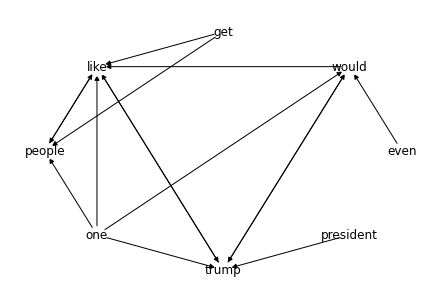

In [ ]:
import networkx as nx
G=nx.DiGraph()
N = len(res)

for i in range(N):
  for a in res.iloc[i].antecedents:
    for c in res.iloc[i].consequents:
      G.add_edge(a, c)

#pos = nx.spring_layout(G, k=0.15, iterations=200)
pos = nx.circular_layout(G)
nx.draw(G, pos, with_labels=True, node_color='white')
plt.show()

In [ ]:
res.describe()

,antecedent support,consequent support,support,confidence,lift,leverage,conviction
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
mean,0.117085,0.143376,0.028251,0.255067,1.781306,0.011482,1.164580
std,0.030754,0.011484,0.005112,0.074551,0.481370,0.002739,0.158220
min,0.043478,0.123086,0.022045,0.204724,1.342347,0.005935,1.067301
25%,0.105634,0.144519,0.023882,0.217033,1.519120,0.010187,1.099652
50%,0.111451,0.145132,0.027557,0.236287,1.663259,0.011719,1.123932
75%,0.144825,0.150337,0.033068,0.252235,1.741806,0.013228,1.136427
max,0.155542,0.155542,0.035517,0.507042,3.259843,0.015283,1.713043


# Associação (não tóxicos)

In [9]:
df = pd.read_csv('/content/drive/Shareddrives/Mineração de Dados/data/all_data.csv')
df = df.dropna(subset=['comment_text', 'toxicity'])
df = df.sample(frac=0.05, random_state=42)
X = df.comment_text[df.toxicity < 0.5]
df = None
stop_words = nltk.corpus.stopwords.words('english')
vect = CountVectorizer(binary = True, stop_words=stop_words, token_pattern='[A-Za-z]+', max_features=1000)
X = vect.fit_transform(X)

In [ ]:
association = pd.DataFrame(X.toarray(), columns=vect.get_feature_names())
freq_itemsets = apriori(association, min_support=0.02, use_colnames=True)
pd.set_option('display.max_rows', 500)
res = association_rules(freq_itemsets, metric='confidence', min_threshold=0.2)
res

In [ ]:
import networkx as nx
G=nx.DiGraph()
N = len(res)

for i in range(N):
  for a in res.iloc[i].antecedents:
    for c in res.iloc[i].consequents:
      G.add_edge(a, c)

#pos = nx.spring_layout(G, k=0.15, iterations=200)
pos = nx.circular_layout(G)
nx.draw(G, pos, with_labels=True, node_color='white')
plt.show()

# Embedding

In [ ]:
df = pd.read_csv('/content/drive/Shareddrives/Mineração de Dados/data/all_data.csv')
df = df.dropna(subset=['comment_text', 'toxicity'])
df = df.sample(frac=0.1, random_state=42)
X = df.comment_text
y = df.toxicity < 0.5
df = None
tknzr = TweetTokenizer()

In [ ]:
tmp_X, tmp_y = RandomUnderSampler(random_state=42).fit_resample(X.to_numpy().reshape(-1,1), y)

vect = CountVectorizer(tokenizer=tknzr.tokenize)
tmp_texts = vect.fit_transform(tmp_X.flatten()[tmp_y < 0.5])
freq = tmp_texts.toarray().sum(axis=0)
words = vect.get_feature_names()
freq_words_not_tox = dict(zip(words, freq))

vect = CountVectorizer(tokenizer=tknzr.tokenize)
tmp_texts = vect.fit_transform(tmp_X.flatten()[tmp_y >= 0.5])
freq = tmp_texts.toarray().sum(axis=0)
words = vect.get_feature_names()
freq_words_tox = dict(zip(words, freq))

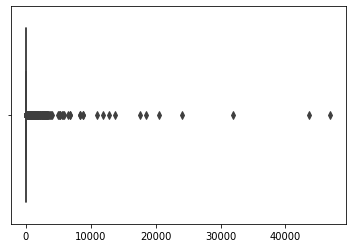

In [ ]:
sns.boxplot(list(freq_words_tox.values()))

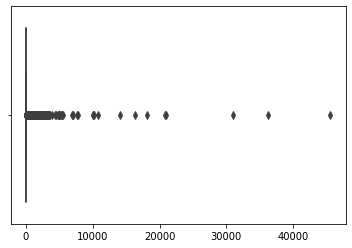

In [ ]:
sns.boxplot(list(freq_words_not_tox.values()))

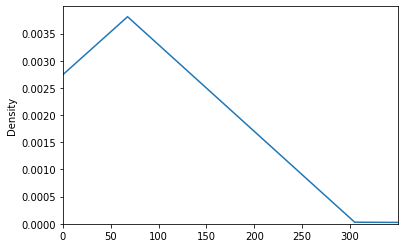

In [ ]:
fig, ax = plt.subplots()
sns.kdeplot(list(freq_words_tox.values()), ax=ax)
ax.set_xlim(0, 350)
ax.set_xticks(range(0, 350, 50))
plt.show()

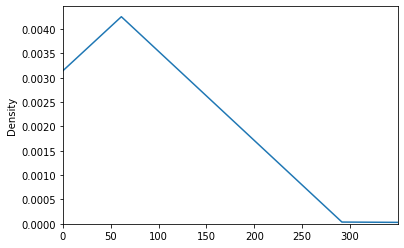

In [ ]:
fig, ax = plt.subplots()
sns.kdeplot(list(freq_words_not_tox.values()), ax=ax)
ax.set_xlim(0, 350)
ax.set_xticks(range(0, 350, 50))
plt.show()

In [ ]:
import statsmodels.stats.api as sms

print(sms.DescrStatsW(list(freq_words_not_tox.values())).tconfint_mean())
print(sms.DescrStatsW(list(freq_words_tox.values())).tconfint_mean())

(20.977489841177483, 30.64553058572176)
(20.174207489483766, 29.584860678120986)


In [ ]:
freq_ones = [(k, v) for k, v in freq_words_not_tox.items() if v>=20 and v<=30]

In [ ]:
freq_ones

[('13', 27),
 ('14', 27),
 ('16', 24),
 ('17', 29),
 ('200', 20),
 ('2019', 25),
 ('3rd', 25),
 ('500', 25),
 ('80', 30),
 ('9', 25),
 ('9/11', 24),
 (':)', 26),
 ('^', 23),
 ('abusing', 20),
 ('abusive', 23),
 ('aca', 29),
 ('accepted', 24),
 ('accepting', 21),
 ('accident', 22),
 ('accomplished', 22),
 ('accounts', 24),
 ('accuse', 22),
 ('acknowledge', 23),
 ('active', 23),
 ('activists', 24),
 ('activities', 29),
 ('added', 25),
 ('addicts', 27),
 ('advertising', 22),
 ('affordable', 23),
 ('ag', 24),
 ('agencies', 29),
 ('airport', 24),
 ('aliens', 30),
 ('allah', 24),
 ('allegations', 24),
 ('allows', 29),
 ('alright', 20),
 ('analysis', 27),
 ('ancestors', 20),
 ('annual', 21),
 ('answers', 20),
 ('anti-american', 22),
 ('apologists', 25),
 ('apology', 20),
 ('apparent', 20),
 ('apple', 21),
 ('applied', 20),
 ('appointed', 23),
 ('appreciate', 28),
 ('approach', 30),
 ('approval', 26),
 ('approve', 23),
 ('arm', 24),
 ('arrest', 21),
 ('arse', 20),
 ('art', 30),
 ('artist', 24)

In [ ]:
stop_words = set(nltk.corpus.stopwords.words('english'))

texts = X.str.lower()
texts = texts.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

X = texts.apply(tknzr.tokenize)

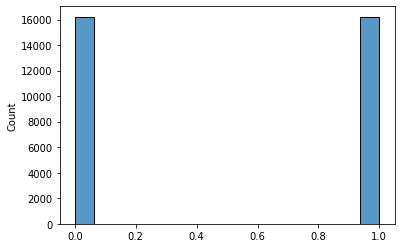

In [ ]:
X, y = RandomUnderSampler(random_state=42).fit_resample(X.to_numpy().reshape(-1,1), y)
sns.histplot(y)

In [ ]:
emb = Word2Vec(X.flatten(), size=300, min_count=700, workers=8)

In [ ]:
tokens = []
labels = []

for word in emb.wv.vocab:
  tokens.append(emb.wv[word])
  labels.append(word)

tsne = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500)
new_values = tsne.fit_transform(tokens)

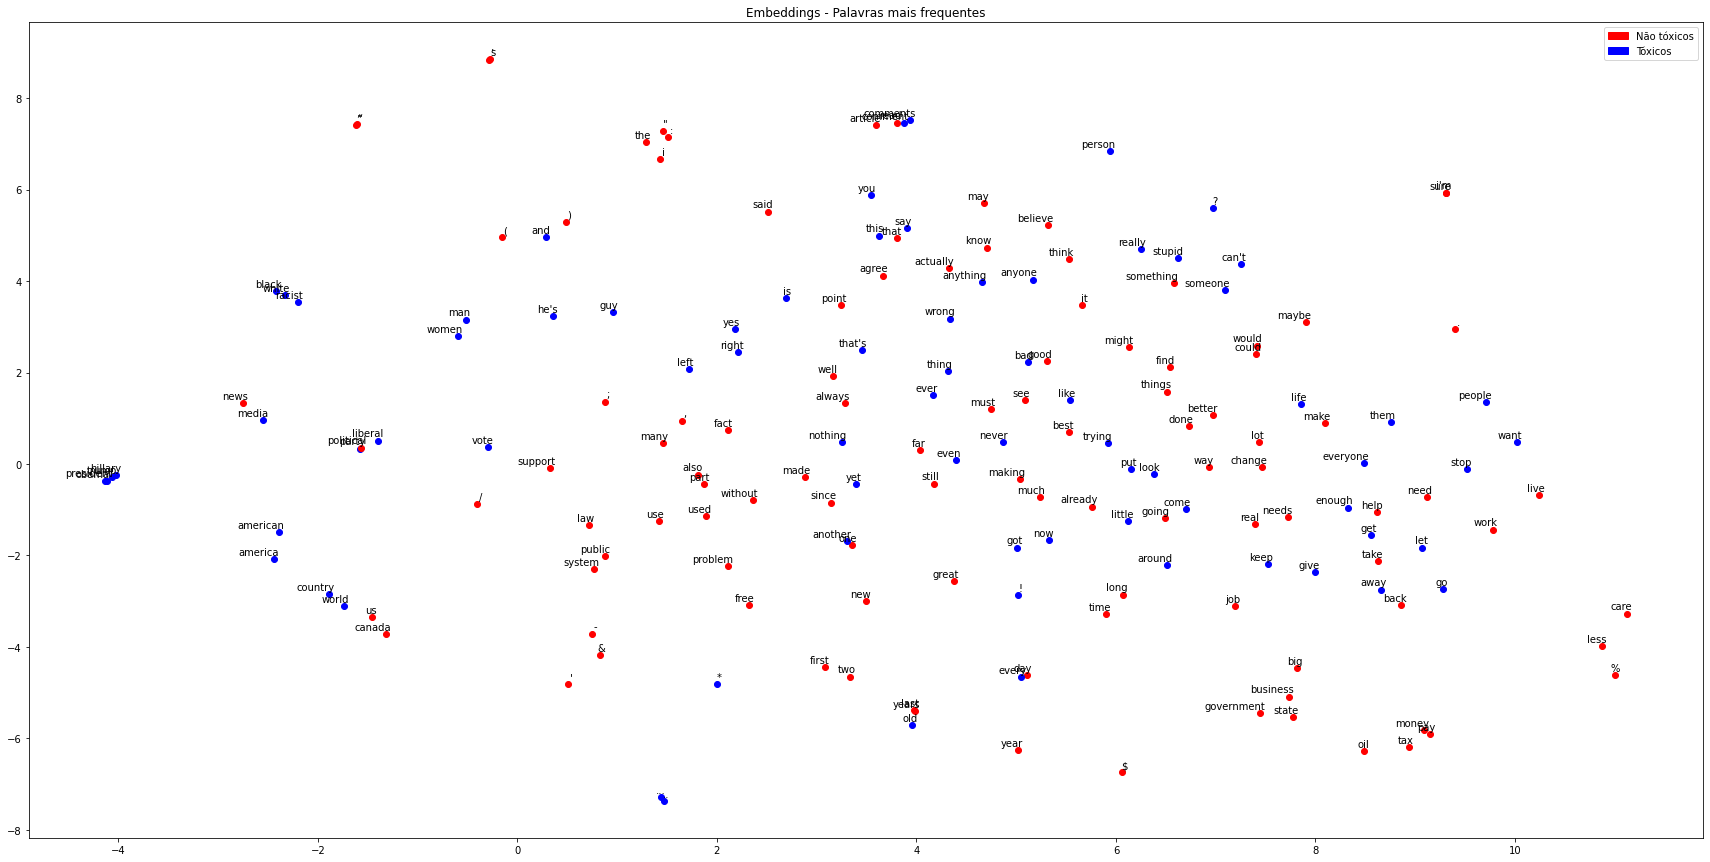

In [ ]:
l1 = mpatches.Patch(color='red', label='Não tóxicos')
l2 = mpatches.Patch(color='blue', label='Tóxicos')

x = []
y = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])
    
plt.figure(figsize=(30, 15)) 
for i in range(len(x)):
    if freq_words_tox[labels[i]] > freq_words_not_tox[labels[i]]:
      plt.scatter(x[i],y[i], color = 'red')
    else:
      plt.scatter(x[i],y[i], color = 'blue')
    plt.annotate(labels[i],
                  xy=(x[i], y[i]),
                  xytext=(5, 2),
                  textcoords='offset points',
                  ha='right',
                  va='bottom')
plt.title("Embeddings - Palavras mais frequentes")
plt.legend(handles=[l1, l2])
plt.show()

# Clustering

In [ ]:
v = np.stack((x, y), axis=-1)

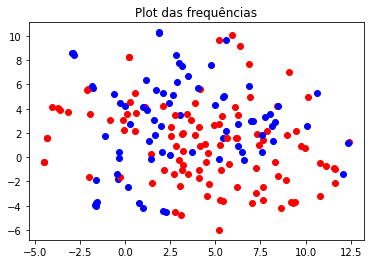

In [ ]:
x = []
y = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])
    
for i in range(len(x)):
    if freq_words_tox[labels[i]] > freq_words_not_tox[labels[i]]:
      plt.scatter(x[i],y[i], color = 'red')
    else:
      plt.scatter(x[i],y[i], color = 'blue')
plt.title("Plot das frequências")
plt.show()

Text(0.5, 1.0, 'KMeans (2 clusters)')

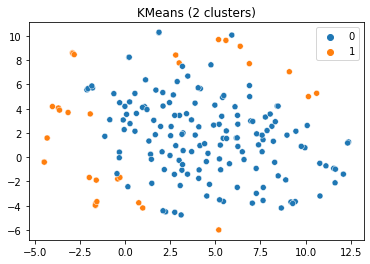

In [ ]:
clustering = KMeans(2).fit(tokens)
sns.scatterplot(v[:,0], v[:,1], hue=clustering.labels_)
plt.title('KMeans (2 clusters)')

Text(0.5, 1.0, 'DBSCAN')

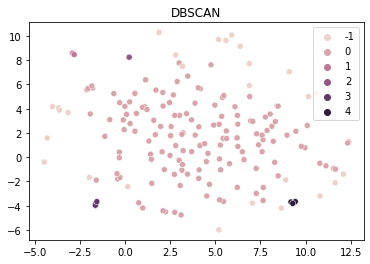

In [ ]:
from sklearn.cluster import DBSCAN

v = np.stack((x, y), axis=-1)
clustering = DBSCAN(eps=3, min_samples=2).fit(tokens)
sns.scatterplot(v[:,0], v[:,1], hue=clustering.labels_)
plt.title('DBSCAN')

# Documentos para embeddings

In [ ]:
tknzr = TweetTokenizer()

df = pd.read_csv('/content/drive/Shareddrives/Mineração de Dados/data/all_data.csv')
df = df.dropna(subset=['comment_text', 'toxicity'])

vect = TfidfVectorizer(tokenizer=tknzr.tokenize)
vect.fit(df.comment_text)

df = df.sample(frac=0.01, random_state=42)
X = df.comment_text
y = df.toxicity < 0.1
df = None

In [ ]:
stop_words = set(nltk.corpus.stopwords.words('english'))

texts = X.str.lower()
texts = texts.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

X = texts.apply(tknzr.tokenize)

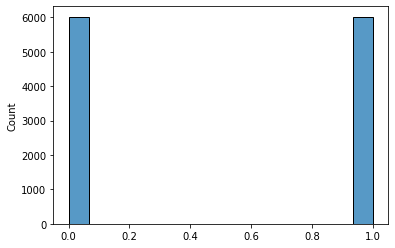

In [ ]:
X, y = RandomUnderSampler(random_state=42).fit_resample(X.to_numpy().reshape(-1,1), y)
sns.histplot(y)

In [ ]:
emb = Word2Vec(X.flatten(), size=300, min_count=1, workers=8)

In [ ]:
def embedding_transform(X, tfidf, w2v):
    # Ref:https://www.kaggle.com/ananyabioinfo/text-classification-using-word2vec
    docs_vectors = pd.DataFrame()
    for doc in X:
      temp = pd.DataFrame()
      for word in doc:
        try:
          word_vec = tfidf[word] * w2v.wv[word]
          temp = temp.append(pd.Series(word_vec), ignore_index = True)
        except:
          pass
      doc_vector = temp.mean()
      docs_vectors = docs_vectors.append(doc_vector, ignore_index = True)
    return docs_vectors

In [ ]:
#pickle.dump(vect, open('/content/drive/Shareddrives/Mineração de Dados/tfidf.sav', 'wb'))

In [ ]:
tfidf_dict = dict(zip(vect.get_feature_names(), vect.idf_))

In [ ]:
X_w2v = embedding_transform(X.flatten(), tfidf_dict, emb)

In [ ]:
#pickle.dump(X_w2v, open('/content/drive/Shareddrives/Mineração de Dados/emb_12000.sav', 'wb'))
#pickle.dump(y, open('/content/drive/Shareddrives/Mineração de Dados/y_12000.sav', 'wb'))
X = pickle.load(open('/content/drive/Shareddrives/Mineração de Dados/modelos/sav//emb_12000.sav', 'rb'))
y = pickle.load(open('/content/drive/Shareddrives/Mineração de Dados/modelos/sav//y_12000.sav', 'rb'))

In [ ]:
mask_delete = np.isnan(X[0])
X = X[~mask_delete]
y = y[~mask_delete]

In [ ]:
rand_index = np.random.choice(X.shape[0], 300, replace=False)  
sample_X = X.iloc[rand_index]
sample_y = y[rand_index]

In [ ]:
tsne = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500)
new_values = tsne.fit_transform(sample_X)

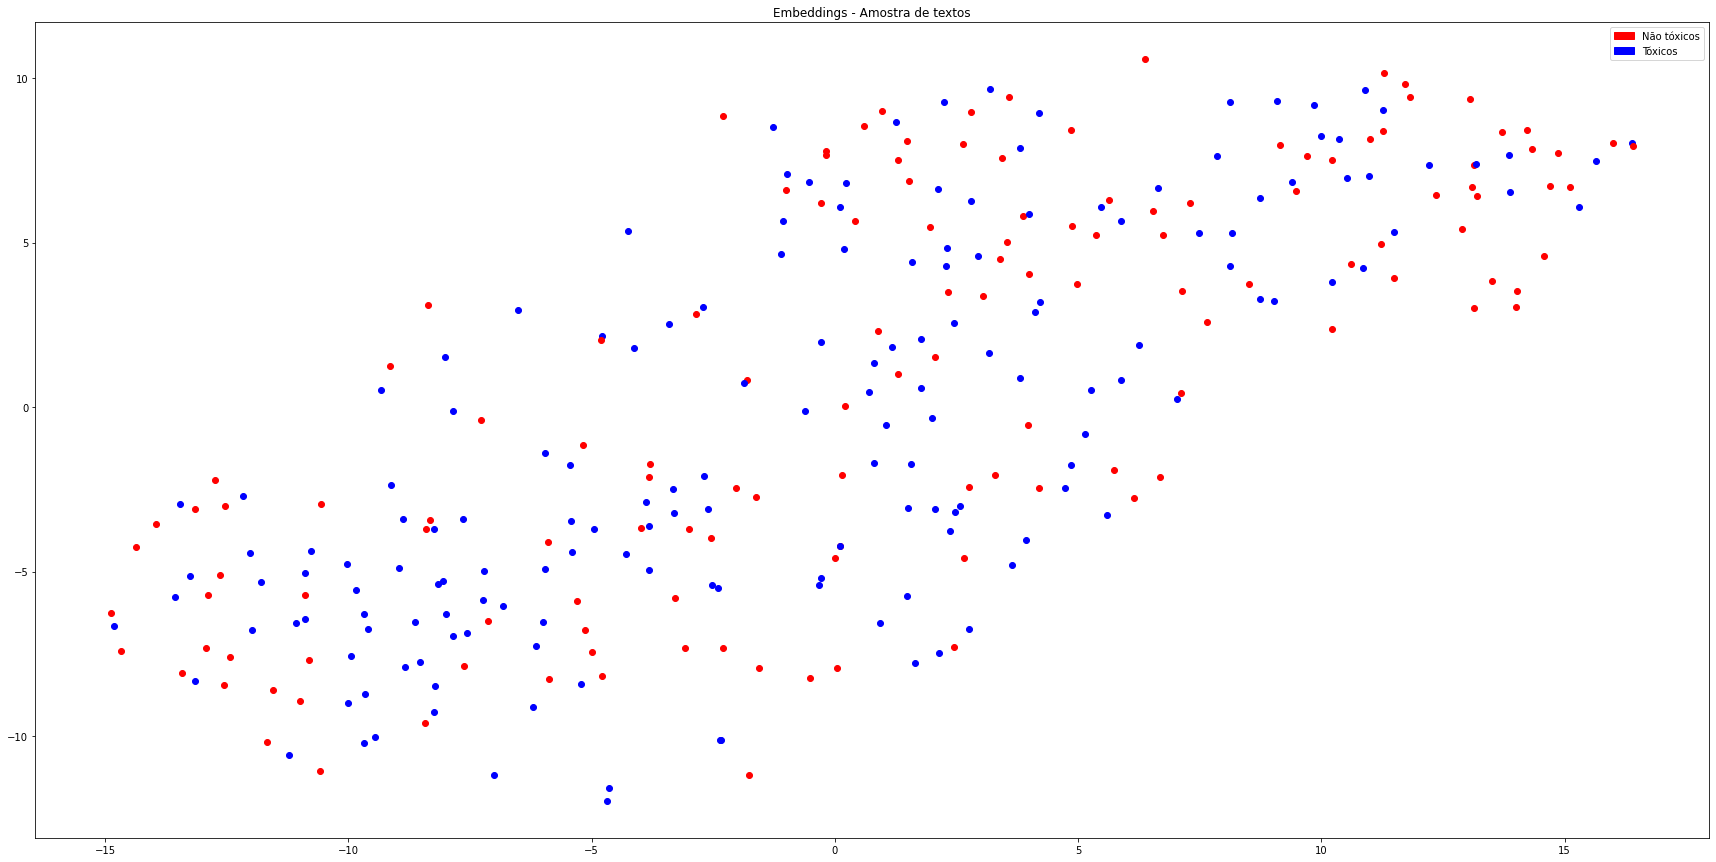

In [ ]:
l1 = mpatches.Patch(color='red', label='Não tóxicos')
l2 = mpatches.Patch(color='blue', label='Tóxicos')

x_axis = []
y_axis = []
for value in new_values:
    x_axis.append(value[0])
    y_axis.append(value[1])
    
plt.figure(figsize=(30, 15)) 
for i in range(len(x)):
    if sample_y[i] == 1:
      plt.scatter(x_axis[i], y_axis[i], color = 'red')
    else:
      plt.scatter(x_axis[i], y_axis[i], color = 'blue')
plt.title("Embeddings - Amostra de textos")
plt.legend(handles=[l1, l2])
plt.show()

# Classificação

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42)

In [ ]:
from sklearn.naive_bayes import BernoulliNB

clf = BernoulliNB().fit(X_train, y_train)
clf.score(X_test, y_test)

0.5606513791957461